In [2]:
import os
import datetime
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm

# 1. Przygotowanie danych z czujnika

In [3]:
recording_list_files = os.listdir('sensor')
print(recording_list_files)

['2022-12-03T184634_data.txt', '2022-12-03T184735_data.txt', '2022-12-03T184836_data.txt', '2022-12-03T184937_data.txt', '2022-12-03T185037_data.txt', '2022-12-03T185138_data.txt', '2022-12-03T185239_data.txt', '2022-12-03T185340_data.txt', '2022-12-03T185440_data.txt', '2022-12-03T185541_data.txt', '2022-12-03T185642_data.txt', '2022-12-03T185742_data.txt', '2022-12-03T185843_data.txt', '2022-12-03T185944_data.txt', '2022-12-03T190045_data.txt', '2022-12-03T190145_data.txt', '2022-12-03T190207_data.txt', '2022-12-03T190308_data.txt', '2022-12-03T190409_data.txt', '2022-12-03T190509_data.txt', '2022-12-03T190610_data.txt', '2022-12-03T190711_data.txt', '2022-12-03T190812_data.txt', '2022-12-03T190912_data.txt', '2022-12-03T191013_data.txt', '2022-12-03T191114_data.txt', '2022-12-03T191215_data.txt', '2022-12-03T191316_data.txt', '2022-12-03T191445_data.txt', '2022-12-03T191545_data.txt', '2022-12-03T191646_data.txt', '2022-12-03T191747_data.txt', '2022-12-03T191848_data.txt', '2022-12-

In [4]:
recordings = []
for filename in recording_list_files:
    file_dir = os.path.join('sensor', filename)
    file = open(file_dir, 'r').read()
    file_split = file.split('\n')[:-1]
    for x in file_split:
        e = x.split(';')
        e[0] = float(e[0])
        e[1] = int(e[1])
        e[2] = int(e[2])
        # e[0] = datetime.datetime.fromtimestamp(e[0])
        recordings.append(e)

print(recordings[0:20])

[[1670089595.191516, 3864, 1], [1670089595.215675, 3889, 1], [1670089595.24067, 3914, 1], [1670089595.26567, 3939, 2], [1670089595.290674, 3964, 2], [1670089595.315688, 3989, 2], [1670089595.340675, 4014, 2], [1670089595.365674, 4039, 1], [1670089595.390674, 4064, 1], [1670089595.415674, 4089, 1], [1670089595.440679, 4114, 1], [1670089595.465675, 4139, 1], [1670089595.490674, 4164, 1], [1670089595.515674, 4189, 1], [1670089595.540679, 4214, 1], [1670089595.565675, 4239, 1], [1670089595.590674, 4264, 1], [1670089595.615674, 4289, 1], [1670089595.640674, 4314, 1], [1670089595.665679, 4339, 1]]


## 1.2 Odstępy czasowe pomiędzy próbkami

Dzięki temu możliwe jest odzielenie ich do 3 poszczególnych nagrań video

Id of new recordings: 35924
Id of new recordings: 62235


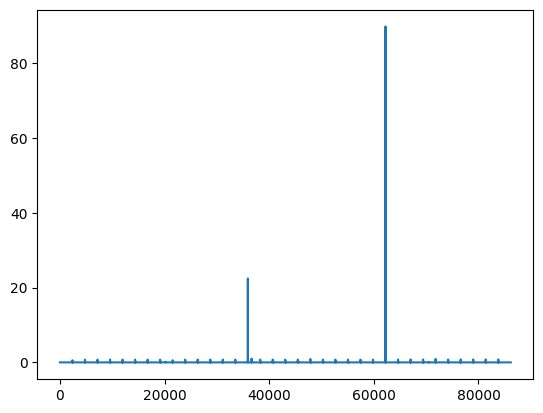

In [5]:
rs = []
recordings_new_id = []
for a in range(len(recordings) - 1):
    x = recordings[a]
    y = recordings[a + 1]
    r = y[0] - x[0]
    rs.append(r)

    if r > 10:
        print(f'Id of new recordings: {a}')
        recordings_new_id.append(a)

plt.plot(rs)
plt.show()

## 1.3 Odstępy pomiędzy podzielonymi próbkami
Podczas tworzenia nowego pliku można zauważyć duży odstęp

[35924, 62235]


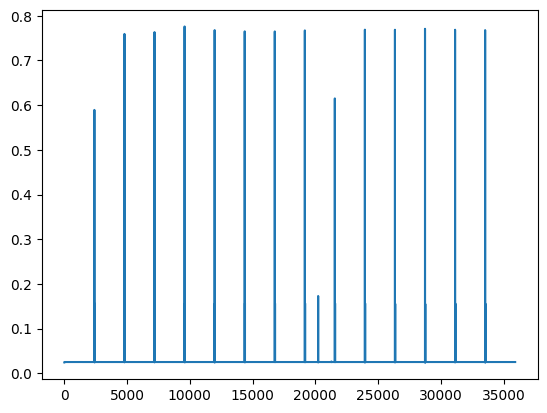

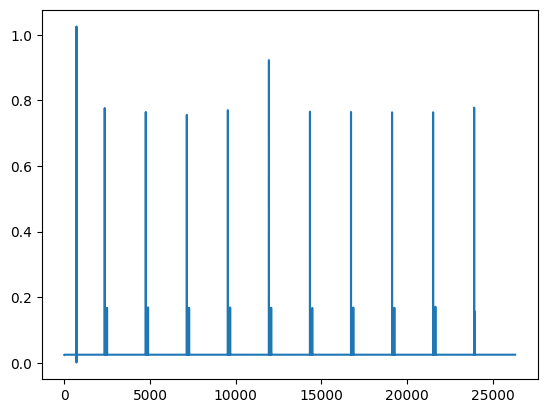

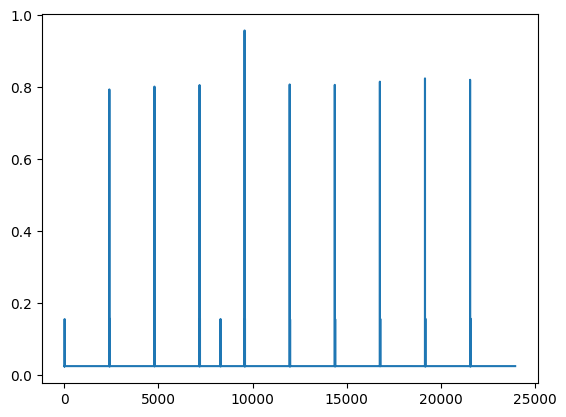

In [6]:
print(recordings_new_id)
recordings_divided = [
    recordings[:recordings_new_id[0]],
    recordings[recordings_new_id[0] + 1: recordings_new_id[1]],
    recordings[recordings_new_id[1] + 1:]
]

for recording_divided in recordings_divided:
    rs = []
    for a in range(len(recording_divided) - 1):
        x = recording_divided[a]
        y = recording_divided[a + 1]
        r = y[0] - x[0]
        rs.append(r)
    plt.plot(rs)
    plt.show()



## 1.4 Dodanie czasu względnego zamiast bezwzględnego

Dodatkowo zmiena jednostki do czasu fps w video

In [7]:
def round_to_multiple(number, multiple):
    return round(multiple * round(number / multiple), 2)


fps = 25
separation = 1 / 25

In [8]:
recordings_relative_divided = []
for recordings in recordings_divided:
    relative_times = set()  #Czasy nie powinny się powtarzać
    recordings_relative = []
    for i in range(len(recordings)):
        if i == 0:
            recordings_relative.append([0, recordings[i][1], recordings[i][2]])
            continue
        x = recordings[0]
        y = recordings[i]
        relative_time = y[0] - x[0]
        relative_time = round_to_multiple(relative_time, separation)
        # Jak czas się powtarza to jest pomijany
        if relative_time in relative_times:
            continue

        relative_times.add(relative_time)
        recordings_relative.append([relative_time, recordings[i][1], recordings[i][2]])
    recordings_relative_divided.append(recordings_relative)
print(recordings_relative_divided[0][:10])

[[0, 3864, 1], [0.04, 3889, 1], [0.08, 3939, 2], [0.12, 3989, 2], [0.16, 4014, 2], [0.2, 4064, 1], [0.24, 4089, 1], [0.28, 4139, 1], [0.32, 4189, 1], [0.36, 4214, 1]]


# 2. Nagrania video

In [9]:
video_list_files = os.listdir('videos')
print(video_list_files)

['GOPR1075.MP4', 'GOPR1076.MP4', 'GOPR1077.MP4']


## 2.1 Zbadanie średniej jasności pikseli

In [10]:
frames_light_times = []
for video_name in video_list_files:
    video_path = os.path.join('videos', video_name)
    cap = cv2.VideoCapture(video_path)
    frames_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    video_time = frames_count / fps
    frames_light_time = []

    if (cap.isOpened() == False):
        print("Error opening video stream or file")

    pbar = tqdm(total=frames_count)
    succ = fail = 0
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            fail += 1
            continue
        else:
            succ += 1
        if succ == frames_count:
            break

        # cv2.imshow('Frame',frame)
        frame_light = round(np.average(frame) / 256, 2)
        frame_time = round(succ / fps, 2)
        frames_light_time.append([frame_light, frame_time])

        pbar.update(1)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

    # print(succ, fail)
    cap.release()
    cv2.destroyAllWindows()
    frames_light_times.append(frames_light_time)

100%|█████████▉| 22236/22244.0 [01:45<00:00, 214.90it/s]
100%|█████████▉| 22243/22244.0 [01:45<00:00, 210.35it/s]

  0%|          | 11/17354.0 [00:01<41:16,  7.00it/s]
  0%|          | 30/17354.0 [00:01<12:59, 22.23it/s]
  0%|          | 52/17354.0 [00:01<06:44, 42.80it/s]
  0%|          | 74/17354.0 [00:01<04:25, 65.13it/s]
  1%|          | 93/17354.0 [00:02<03:27, 83.29it/s]
  1%|          | 113/17354.0 [00:02<02:48, 102.53it/s]
  1%|          | 132/17354.0 [00:02<02:26, 117.84it/s]
  1%|          | 153/17354.0 [00:02<02:07, 135.20it/s]
  1%|          | 174/17354.0 [00:02<01:54, 149.50it/s]
  1%|          | 194/17354.0 [00:02<01:48, 157.82it/s]
  1%|          | 216/17354.0 [00:02<01:41, 169.54it/s]
  1%|▏         | 237/17354.0 [00:02<01:37, 175.50it/s]
  1%|▏         | 258/17354.0 [00:02<01:35, 179.78it/s]
  2%|▏         | 277/17354.0 [00:02<01:36, 177.81it/s]
  2%|▏         | 297/17354.0 [00:03<01:35, 179.24it/s]
  2%|▏         | 319/17354.0 [00:03<01:31, 185.44it/s]
  2%|▏         

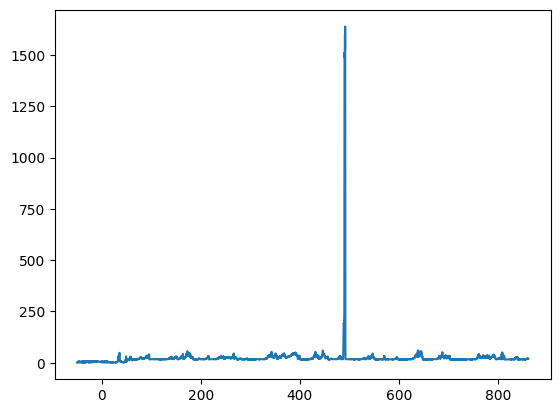

In [11]:
# print(frames_light_time[:10])
light_y = [x[0] for x in frames_light_times[0]]
light_x = [x[1] for x in frames_light_times[0]]

recordings_moved = [[x[0] - 49, x[1], x[2]] for x in recordings_relative_divided[0]]
# print(recordings_relative_divided[0][:10])
record_y = [x[2] for x in recordings_moved]
# record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
# plt.plot(light_x, light_y)

plt.show()

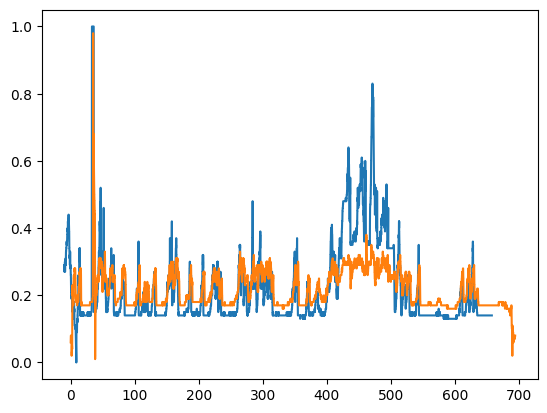

In [12]:
light_y = [x[0] for x in frames_light_times[1]]
light_x = [x[1] for x in frames_light_times[1]]

recordings_moved = [[x[0] - 10, x[1], x[2]] for x in recordings_relative_divided[1]]
record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)

plt.show()

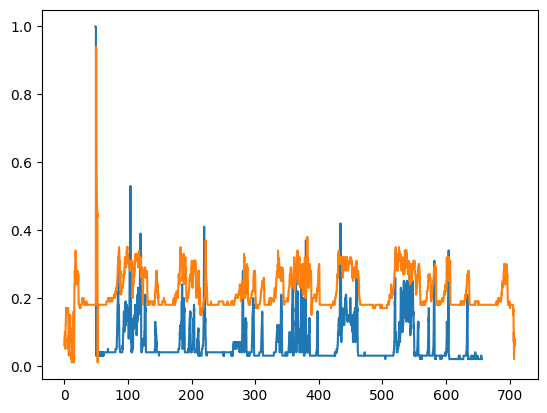

In [13]:
light_y = [x[0] for x in frames_light_times[2]]
light_x = [x[1] for x in frames_light_times[2]]

recordings_moved = [[x[0] + 49, x[1], x[2]] for x in recordings_relative_divided[2]]
ys = record_y = [x[2] for x in recordings_moved]
record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)
# plt.plot(record_x, record_y)
plt.show()

## 2.2 Przesunięcie recordings o daną wartość

In [14]:
move_recording_values = [-49, -10, 50]

In [15]:
recordings_moved_all = []
outlier_value = 100
for recordings, move_value in zip(recordings_relative_divided, move_recording_values):
    recordings_moved = []
    for x in recordings:
        new_x2 = x[2] / outlier_value if x[2] < outlier_value else 1
        new_x0 = x[0] + move_value
        recordings_moved.append([new_x0, x[1], new_x2])

    recordings_moved_all.append(recordings_moved)

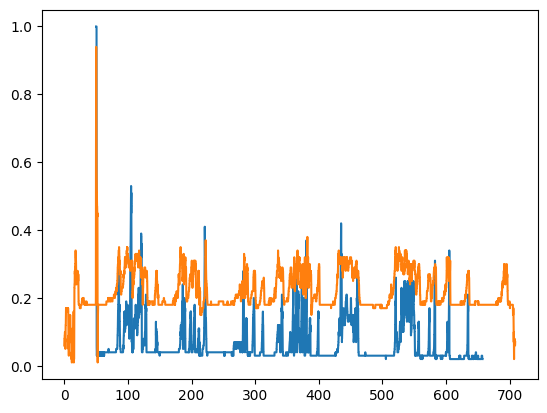

In [16]:
n = 2
light_y = [x[0] for x in frames_light_times[n]]
light_x = [x[1] for x in frames_light_times[n]]

record_y = [x[2] for x in recordings_moved_all[n]]
record_x = [x[0] for x in recordings_moved_all[n]]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)
plt.show()

## 2.3 Obcięcie nagrań (do tej samej długości)

In [17]:
data = []
for i in range(len(recordings_moved_all)):
    d = []
    for r in tqdm(recordings_moved_all[i]):
        for frame_id, f in enumerate(frames_light_times[i]):
            if r[0] == f[1]:
                # d.append([frame_id, r[0], r[2], f[0]])
                d.append([frame_id, r[2], ])
                continue
    data.append(d)

print(data[0][:10])



 36%|███▌      | 8004/22464 [00:15<00:24, 584.40it/s]
100%|█████████▉| 17714/17715.0 [01:52<00:00, 195.68it/s]
100%|██████████| 22464/22464 [00:41<00:00, 536.22it/s]

100%|██████████| 16453/16453 [00:26<00:00, 630.84it/s]

100%|██████████| 14974/14974 [00:22<00:00, 659.74it/s]

[[24, 0.04], [49, 0.05], [74, 0.02], [99, 0.03], [107, 0.03], [116, 0.03], [124, 0.02], [132, 0.05], [141, 0.06], [149, 0.08]]


In [18]:
for x in data[0][500:600]:
    print(x)
print(len(data[0]))

[1422, 0.24]
[1424, 0.21]
[1426, 0.22]
[1428, 0.22]
[1429, 0.23]
[1431, 0.26]
[1433, 0.26]
[1435, 0.25]
[1438, 0.26]
[1440, 0.27]
[1442, 0.28]
[1444, 0.29]
[1445, 0.29]
[1447, 0.27]
[1449, 0.25]
[1451, 0.25]
[1453, 0.25]
[1454, 0.25]
[1456, 0.25]
[1458, 0.25]
[1460, 0.25]
[1463, 0.27]
[1465, 0.28]
[1467, 0.26]
[1469, 0.26]
[1470, 0.26]
[1472, 0.25]
[1474, 0.26]
[1476, 0.26]
[1478, 0.27]
[1479, 0.27]
[1481, 0.26]
[1483, 0.24]
[1485, 0.24]
[1488, 0.24]
[1490, 0.23]
[1492, 0.2]
[1494, 0.2]
[1495, 0.2]
[1497, 0.19]
[1499, 0.19]
[1501, 0.19]
[1503, 0.16]
[1504, 0.16]
[1506, 0.15]
[1508, 0.16]
[1510, 0.15]
[1513, 0.14]
[1515, 0.14]
[1517, 0.14]
[1519, 0.14]
[1520, 0.14]
[1522, 0.14]
[1524, 0.14]
[1526, 0.14]
[1528, 0.13]
[1529, 0.13]
[1531, 0.13]
[1533, 0.13]
[1535, 0.12]
[1538, 0.13]
[1540, 0.13]
[1542, 0.14]
[1544, 0.13]
[1545, 0.13]
[1547, 0.12]
[1549, 0.13]
[1551, 0.13]
[1553, 0.13]
[1554, 0.12]
[1556, 0.12]
[1558, 0.12]
[1560, 0.13]
[1563, 0.13]
[1565, 0.13]
[1567, 0.13]
[1569, 0.14]
[1

# 3. Normalizacja

## 3.1 Połączenie w jedną tablicę

In [22]:
data_one = []
for i, x in enumerate(data):
    for y in x:
        data_one.append([f'{i}_{y[0]}', y[1]])

['0_24', 0.04]


## 3.2 Usunięcie wartości odstających

In [28]:
data = []
for id_, value in data_one:
    if value >= 0.8:
        pass
    elif value == 0:
        print(id_, value)
    else:
        data.append([id_, value])


1_220 0.0
[['0_24', 0.04], ['0_49', 0.05], ['0_74', 0.02], ['0_99', 0.03], ['0_107', 0.03], ['0_116', 0.03], ['0_124', 0.02], ['0_132', 0.05], ['0_141', 0.06], ['0_149', 0.08], ['0_157', 0.05], ['0_166', 0.01], ['0_174', 0.01], ['0_182', 0.03], ['0_191', 0.03], ['0_199', 0.03], ['0_200', 0.03], ['0_207', 0.04], ['0_208', 0.04], ['0_215', 0.05], ['0_216', 0.05], ['0_223', 0.03], ['0_224', 0.03], ['0_225', 0.03], ['0_232', 0.05], ['0_233', 0.05], ['0_240', 0.03], ['0_241', 0.03], ['0_248', 0.05], ['0_249', 0.05], ['0_250', 0.05], ['0_257', 0.03], ['0_258', 0.03], ['0_265', 0.02], ['0_266', 0.03], ['0_273', 0.06], ['0_274', 0.06], ['0_290', 0.06], ['0_291', 0.06], ['0_298', 0.06], ['0_299', 0.06], ['0_300', 0.06], ['0_307', 0.02], ['0_308', 0.02], ['0_315', 0.02], ['0_316', 0.02], ['0_323', 0.01], ['0_324', 0.01], ['0_325', 0.02], ['0_332', 0.02], ['0_333', 0.02], ['0_340', 0.02], ['0_341', 0.02], ['0_348', 0.02], ['0_349', 0.02], ['0_350', 0.02], ['0_357', 0.02], ['0_358', 0.02], ['0_365

0.79


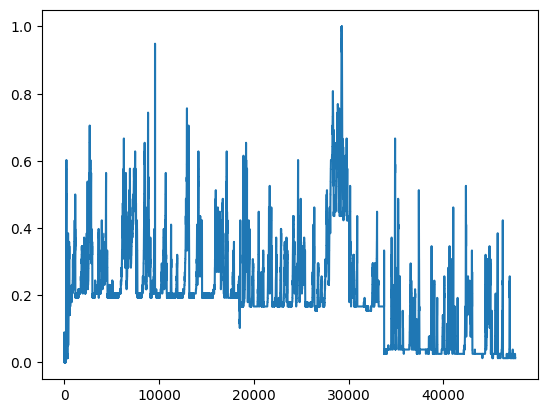

In [50]:
data_np_y = np.array([x[1] for x in data])
# data_np = np.array(data, dtype=object)
std_y = np.std(data_np_y)
min_y = np.min(data_np_y)
max_y = np.max(data_np_y)
print(max_y)

data_normalized_min_max = []
for id_, value in data:
    new_value = (value - min_y) / (max_y - min_y)
    data_normalized_min_max.append([id_, new_value])

plt.plot([b for a, b in data_normalized_min_max])
plt.show()

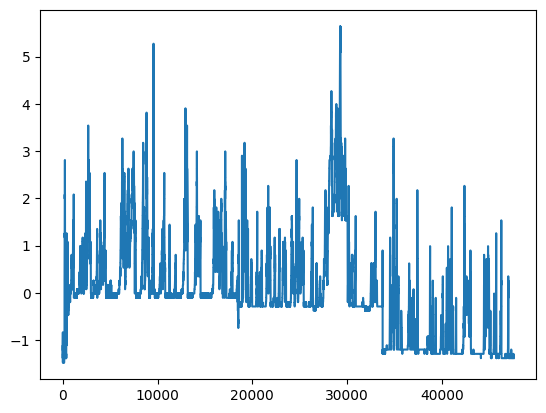

In [51]:
data_np_y = np.array([x[1] for x in data])

std_y = np.std(data_np_y)
mean = np.mean(data_np_y)

data_normalized_z_score = []
for id_, value in data:
    new_value = (value - mean) / std_y
    data_normalized_z_score.append([id_, new_value])

plt.plot([b for a, b in data_normalized_z_score])
plt.show()

# 4. Zapisanie danych

In [52]:
import csv

f = open(f"z_score.csv", 'w', newline='', encoding='utf-8')
writer = csv.writer(f)
writer.writerows(data_normalized_z_score)
f.close()

In [53]:
f = open(f"min_max.csv", 'w', newline='', encoding='utf-8')
writer = csv.writer(f)
writer.writerows(data_normalized_min_max)
f.close()